In [4]:
#Set up DrWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pde_functions.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");
include("/home/jm2386/Active_Lattice/src/plot_functions.jl");

   Resolving package versions...


  No Changes to `/mhome/damtp/s/jm2386/Active_Lattice/Project.toml`
  No Changes to `/mhome/damtp/s/jm2386/Active_Lattice/Manifest.toml`


In [15]:
# set parameters
ϕa = 0.6
ϕp = 0.1
Pe = 7.5
#
ρ = ϕa+ϕp
χ = ϕa/ρ
pert = "pm_lin"
    T  = 0.1
    δ  = 1e-4
    save_interval = 0.0001
    Dx = 1. 
    Dθ = 10000.0
    Nx = 512
    Nθ = 2
name = "pm_bin_test_5_pde_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);

In [16]:
initial_Δ = 1e-4;
max_iter = 40;
tol = 1e-3;
atol = 1e-12;
rho_max = (1-10e-20);
γ = (1-ϕa)/(1-ρ)
find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
ϕg = lower_limits[1]
ϕl = upper_limits[1]
ϕag, ϕpg = gamma_converter(γ, ϕg)
ϕal, ϕpl = gamma_converter(γ, ϕl)



(0.9212087394537744, 0.01969781513655644)

In [17]:
# set liquid parameters
ϕa = ϕal
ϕp = ϕpl
Pe = 7.5
#
ρ = ϕa+ϕp
χ = ϕa/ρ
pert = "pm_lin"
    T  = 0.1
    δ  = 1e-4
    save_interval = 0.0001
    Dx = 1. 
    Dθ = 10000.0
    Nx = 512
    Nθ = 2
name = "pm_bin_test_5_pde_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);

In [20]:
function pm_lin_pert(param)
    @unpack S, ρa, ρp, λ, Nx, Nθ, Dx, Pe, Dθ, γ = param
    ω = 2*π/sqrt(Dθ);
    ϕa = ρa;
    ϕp = ρp;
    ϕ  = ϕa + ϕp;
    ϕ0 = 1- ϕ;
    ds = self_diff(ϕ);
    dsp = self_diff_prime(ϕ);
    DD = (1-ds)/ϕ
    s = DD - 1
    W = [-ω^2             0          -im*ω*Pe*ϕ0; 
        -ω^2*ϕa*DD      -ω^2*ds     -im*ω*Pe*(ϕa*s+ds); 
        -im*ω*Pe*ϕa*dsp -im*ω*Pe*ds -ω^2*ds-2         ]
    values,vectors = eigen(W)
    return ω, values[3], vectors[:,3]
end
ω, value, vector = pm_lin_pert(param)
# ω = 2*π/sqrt(Dθ)
# (ω^2/4/ϕ)*is_stable_value(ϕa, ϕp; Pe = Pe)

(0.06283185307179587, -0.0001249736725255889 + 0.0im, ComplexF64[-0.28599439458998016 + 0.0im, 0.9574266261267796 + 0.0im, 0.0 - 0.03926145497307153im])

In [21]:
#initiate pde
@unpack T, save_interval, max_steps, pert, δ = param
density = initialize_density_pm(param)
perturb_pde_pm!(param, density; δ = 1e-4, pert = "pm_lin")
T = 0.01
run_pde_until_pm!(param,density,T; save_on = true, max_steps = max_steps, save_interval = save_interval)

23100

In [23]:
include("/home/jm2386/Active_Lattice/src/plot_functions.jl");

function animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = 99, ϕg = 0.0, ϕl = 1.0)
    @unpack name, λ, ρa, ρp, Nx, Nθ, δt, Dθ, χ, γ = param
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    N = length(t_saves)
    function makeframe(i)
        clf()
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        axs = ax1, ax2
        vid_pde_plot_pm(fig, axs, param, t_saves, fa_saves, fp_saves, i+1)
        binod_liquid = ax1.plot(t_saves, ϕl*ones(N), color = "black", linestyle = "--", label = "_liquid phase")
        binod_gas = ax1.plot(t_saves, ϕg*ones(N), color = "black",linestyle = "--", label = "_gas phase")
        return fig
    end
    interval = 5*Int64(round(20000/frames))
    myanim = anim.FuncAnimation(fig, makeframe, frames=frames, interval=interval)
    # Convert it to an MP4 movie file and saved on disk in this format.
    T = t_saves[Int64(round((frames+1)))]
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)/time=$(round(T; digits = 5))_Nx=$(Nx)_Nθ=$(Nθ)_active=$(ρa)_passive=$(ρp)_lamb=$(λ).mp4";
    myanim[:save](filename, bitrate=-1, dpi= 100, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function make_phase_video_pm(param; skip_factor = 10, ϕg = 0.0, ϕl = 1.0)
    @unpack T, save_interval = param
    save_interval = save_interval*skip_factor
    t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval)
    frames = Int64(length(t_saves))
    animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = frames-1,ϕg =ϕg, ϕl = ϕl)
end

function vid_pde_plot_pm(fig::Figure, axs, param::Dict{String,Any}, t_saves, fa_saves, fp_saves, i)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe = param
    ρa_saves, ρp_saves = deepcopy(spatial_density_pm.(fa_saves)), deepcopy(fp_saves)

    push!(ρa_saves[i], ρa_saves[i][1])
    push!(ρp_saves[i], ρp_saves[i][1])

    ρsum = ρp_saves[i]+ρa_saves[i]

    axs[1].plot((0:1:Nx)/Nx,ρa_saves[i], color = "red", label = L"\rho^a")
    axs[1].plot((0:1:Nx)/Nx,ρsum, color = "black", label = L"\rho")
    axs[1].plot((0:1:Nx)/Nx,ρp_saves[i], color = "blue", label = L"\rho^p")

    axs[1].xaxis.set_ticks(0.:0.2:1.0)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    rhomax = maximum(maximum(ρa_saves))+maximum(maximum(ρp_saves))
    axs[1].axis([0., 1., 0. , rhomax])
    #axs[1].axis([0., 1., min(minimum(minimum(ρa_saves)),minimum(minimum(ρp_saves))),maximum(maximum( ρa_saves+ρp_saves ))])
    axs[1].set_xlabel(L"x",fontsize=20)
    #axs[1].set_ylabel(L"\rho,",fontsize=20)
    title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ), \\phi = $(ρa+ρp), \\mathrm{Pe} = $(round(Pe; digits = 3)), t = $(round(t_saves[i]; digits = 3))\$")
    axs[1].set_title(title,fontsize=20)

    mat1 = zeros(1, Nx+1)
    mat2= zeros(1, Nx+1)
    mags = mag_pm(fa_saves[i]; Nθ = Nθ)
    push!(mags,mags[1])
    mat1[1, :] = mags
    mat2[1, :] = mags.*(-ρsum.+1)

    #colmap = PyPlot.plt.cm.seismic
    colmap = PyPlot.plt.cm.PRGn
    norm1 = matplotlib.colors.Normalize(vmin= -rhomax*0.5 , vmax= rhomax*0.5) 
    #norm1 = matplotlib.colors.Normalize(vmin= -maximum(abs.(mags)) , vmax= maximum(abs.(mags)) )
    #norm2 = matplotlib.colors.Normalize(vmin= minimum(mags/10) , vmax= maximum(mags)/10 )

    axs[2].matshow(mat1; norm = norm1,  cmap = colmap, extent = [0., 1., 0., 0.1])
    #axs[3].matshow(mat2; norm = norm2,  cmap = colmap, extent = [0., 1., 0., 0.1])

    axs[2].set_aspect(1.)
    #axs[3].set_aspect(1.)

    axs[2].xaxis.set_ticks(0.:0.2:1.0)
    axs[2].yaxis.set_ticks([])
    axs[2].xaxis.set_tick_params(labelsize=15)
    axs[2].xaxis.tick_bottom()
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    #ax.set_xlabel(L"x",fontsize=20)

    axs[2].set_ylabel(L"\mathbf{p}", fontsize=20, rotation=0)
    axs[2].yaxis.set_label_coords(-.05, .5)

    lines, labels = axs[1].get_legend_handles_labels()
    fig.tight_layout()
    ldg = fig.legend(lines, labels, loc = "center right", fontsize=20, bbox_to_anchor = (0.25, 0.25, 1, 1),
    bbox_transform = plt.gcf().transFigure)

    return fig
end

vid_pde_plot_pm (generic function with 1 method)

In [24]:
make_phase_video_pm(param; skip_factor = 1, ϕg =ϕg, ϕl = ϕl)

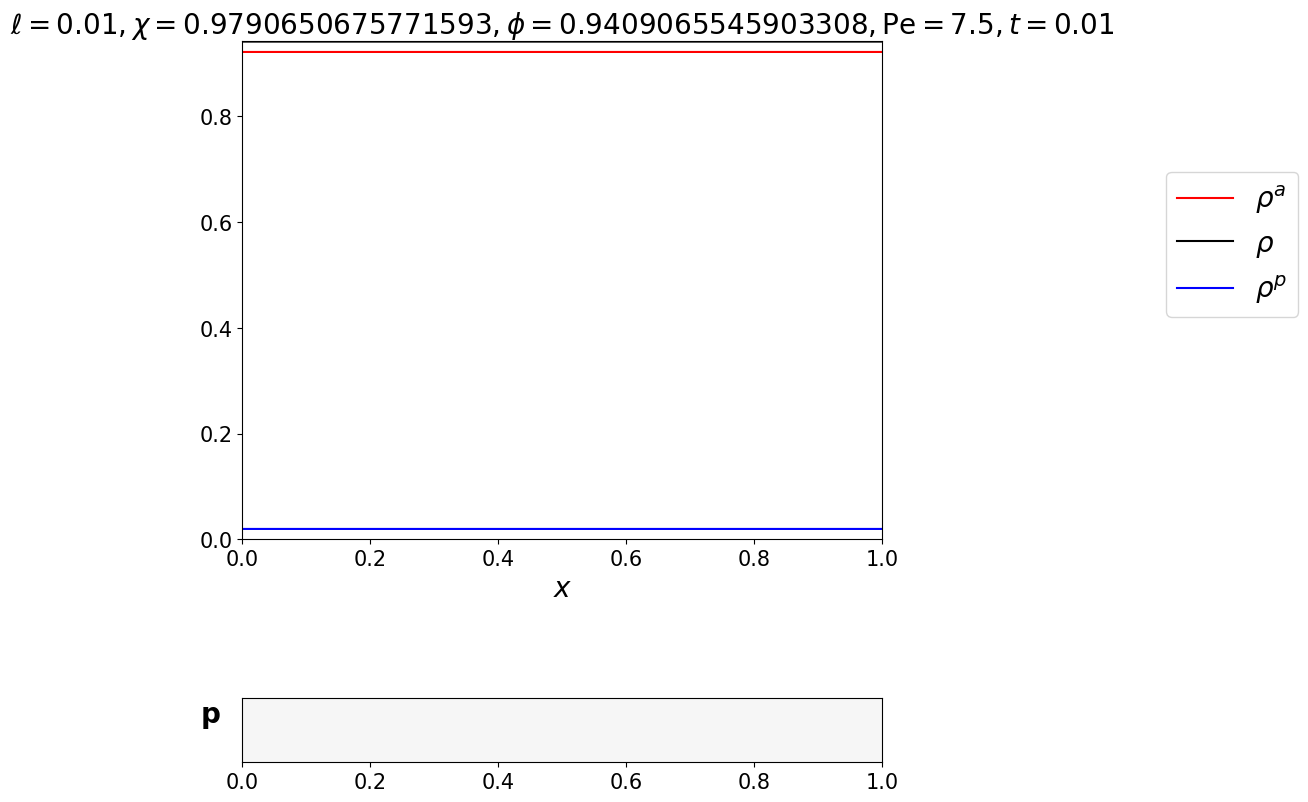

In [25]:
#plot density 
using PyPlot
@unpack t, fa, fp = density 
fig, axs = plt.subplots(2, 1, figsize=(10,10))
vid_pde_plot_pm(fig, axs, param, [t], [fa], [fp], 1)
display(fig)

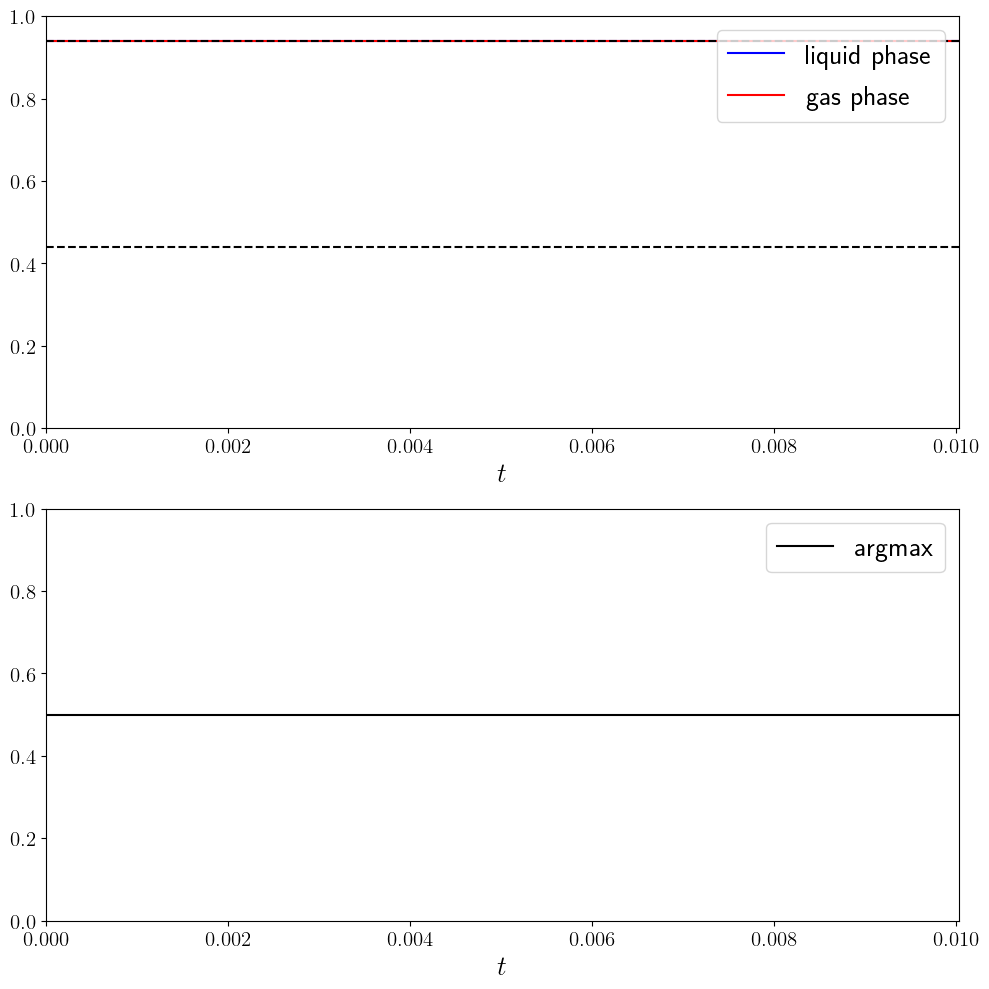

In [26]:
# load solution
function cal_rho_saves(fa, fp; Nθ = Nθ)
    return fp + sum(fa; dims =2)[:,1]
end
t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval);
ρ_saves = cal_rho_saves.(fa_saves, fp_saves; Nθ = Nθ);
ρl_saves =  maximum.(ρ_saves);
ρg_saves =  minimum.(ρ_saves);
xmax_saves = argmax.(ρ_saves)/Nx;

#plot data
using PyPlot
    PyPlot.close("all")
    rc("text", usetex=true)
fig, axs = plt.subplots(2, 1, figsize=(10,10))

#plot binodal

ax = axs[1]
    N = length(t_saves)
    liquid = ax.plot(t_saves, ρl_saves, color = "blue", label = "liquid phase")
    gas = ax.plot(t_saves, ρg_saves, color = "red", label = "gas phase")
    binod_liquid = ax.plot(t_saves, ϕl*ones(N), color = "black", linestyle = "--", label = "_liquid phase")
    binod_gas = ax.plot(t_saves, ϕg*ones(N), color = "black",linestyle = "--", label = "_gas phase")
    #plot phase
    ax = axs[2]
ax.plot(t_saves, xmax_saves, color = "black", label = "argmax")

#axs settings
for ax in axs
    #ax.yaxis.set_ticks(ytic)
    axlim = [0, maximum(t_saves), 0, 1]
    #axlim = [0.4, 0.45, 0, 0.1]
    ax.xaxis.set_tick_params(labelsize=15)
    #ax.xaxis.tick_bottom(t_saves)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_xlabel(L"t",fontsize=20)
    #ax.set_ylabel(L"\phi^p", fontsize=20)
    ax.legend(loc = "upper right", fontsize=20)
    #ax.set_aspect(0.25*Δρ/ΔPe)
end
fig.tight_layout()
display(fig)